In [ ]:
import zipfile
import os

# Specify the path to your ZIP file
zip_file_path = '/content/drive/MyDrive/Deep Learning DataSets/Pothole Segmentation for Road Damage.zip'  # Replace with your actual ZIP file name

# Check if the ZIP file exists
if os.path.exists(zip_file_path):
    # Extract the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('extracted_data')  # Folder where the content will be extracted

    print(f"Extraction complete. Files extracted to 'extracted_data/'")
else:
    print(f"File '{zip_file_path}' not found. Please make sure the ZIP file is in the current directory.")


Extraction complete. Files extracted to 'extracted_data/'


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 15.3 MB/s eta 0:00:00


###**Step1: Setup & Initialization**

In [ ]:
# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from ultralytics import YOLO
from IPython.display import Video

In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

###**Step2: Loading YOLOv8-seg Pre-trained Model**

In [ ]:
# Load the pre-trained YOLOv8 nano segmentation model
model = YOLO('yolov8n-seg.pt')

###**Step3: Dataset Preparation for Model Fine-tuning**

In [ ]:
# Define the dataset_path
dataset_path = '/content/extracted_data/Pothole_Segmentation_YOLOv8'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Pothole
nc: 1
roboflow:
  license: CC BY 4.0
  project: pothole_segmentation_yolov8
  url: https://universe.roboflow.com/farzad/pothole_segmentation_yolov8/dataset/1
  version: 1
  workspace: farzad
train: ../train/images
val: ../valid/images



In [ ]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 720
Number of validation images: 60
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


###**Dataset Analysis Insights**

In [ ]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 15)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_images_path, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Dataset Images', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

###**Step4: Fine-Tuning YOLOv8-seg**



In [ ]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=150,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    patience=15,             # Epochs to wait for no observable improvement for early stopping of training
    batch=16,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate
    lrf=0.01,                # Final learning rate (lr0 * lrf)
    dropout=0.25,            # Use dropout regularization
    device=0,                # Device to run on, i.e. cuda device=0
    seed=42                  # Random seed for reproducibility
)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/extracted_data/Pothole_Segmentation_YOLOv8/data.yaml, epochs=150, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

train: Scanning /content/extracted_data/Pothole_Segmentation_YOLOv8/train/labels.cache... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/extracted_data/Pothole_Segmentation_YOLOv8/valid/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.23G     0.9344      1.531     0.6821      1.072         49        640: 100%|██████████| 45/45 [00:24<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         60        201      0.742      0.637      0.712      0.429      0.743      0.647      0.731      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.86G     0.9641       1.59     0.7179      1.096         85        640: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         60        201      0.591      0.677      0.652      0.377      0.783      0.539      0.659      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.81G     0.9846      1.598      0.722      1.103         82        640: 100%|██████████| 45/45 [00:20<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         60        201      0.703      0.577      0.627       0.37      0.726      0.554      0.626      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.87G      1.044      1.698      0.797       1.13         94        640: 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         60        201      0.632      0.657      0.646      0.369      0.636      0.661      0.648      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.86G      1.065      1.709      0.811      1.145         83        640: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         60        201      0.645      0.612       0.63      0.356      0.624      0.592      0.611      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.85G      1.076      1.732     0.8312       1.14         71        640: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         60        201      0.703      0.672      0.672      0.369      0.716      0.678      0.699      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/150       2.8G      1.084      1.744     0.8356      1.156         89        640: 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         60        201      0.617      0.617      0.611      0.339      0.643      0.597      0.617      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.96G      1.034      1.675     0.7958      1.139         64        640: 100%|██████████| 45/45 [00:21<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         60        201      0.672      0.677      0.677      0.395      0.686      0.692      0.698      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.84G      1.059      1.705     0.8034      1.143         87        640: 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         60        201      0.754      0.483      0.601      0.339      0.794      0.507      0.631      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.86G      1.052      1.712     0.8203      1.145         70        640: 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         60        201      0.641      0.568       0.62      0.363      0.663      0.588      0.642      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.88G      1.065      1.691     0.7983      1.144         78        640: 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         60        201      0.779      0.562      0.665      0.374       0.79      0.572      0.684      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.83G      1.015      1.656     0.7662      1.126         80        640: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         60        201      0.696      0.592      0.628      0.374      0.696      0.592      0.619      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.86G      1.037      1.632     0.7475       1.12         70        640: 100%|██████████| 45/45 [00:20<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         60        201      0.652      0.635      0.659      0.391      0.673      0.635      0.671      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.82G      1.023      1.625     0.7692      1.116         72        640: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         60        201      0.614      0.627      0.679      0.403      0.721      0.532       0.67      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.82G      1.031      1.651     0.7586      1.115         56        640: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         60        201      0.651      0.682      0.653       0.36      0.677      0.699      0.679       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.85G      1.047      1.633     0.7511      1.121         62        640: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         60        201      0.706      0.592      0.637      0.363      0.707        0.6      0.653      0.364
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.101 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 6.8MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


                   all         60        201      0.738      0.637      0.711      0.427      0.681      0.697      0.723      0.412
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train2


###**Step5: Model Performance Evaluation**

In [ ]:
import os

# Define the path to the directory
post_training_files_path = '/content/runs/segment/train'

# List the files in the directory
files = os.listdir(post_training_files_path)
for file in files:
    print(file)


events.out.tfevents.1725536470.d6714d1d451f.1919.0
MaskR_curve.png
confusion_matrix.png
val_batch1_labels.jpg
BoxR_curve.png
train_batch2.jpg
val_batch1_pred.jpg
val_batch0_labels.jpg
MaskP_curve.png
confusion_matrix_normalized.png
results.csv
args.yaml
MaskF1_curve.png
BoxPR_curve.png
weights
labels_correlogram.jpg
val_batch0_pred.jpg
train_batch1.jpg
MaskPR_curve.png
BoxP_curve.png
BoxF1_curve.png
labels.jpg
train_batch0.jpg
results.png


###**Step 5.1: Learning Curves Analysis**

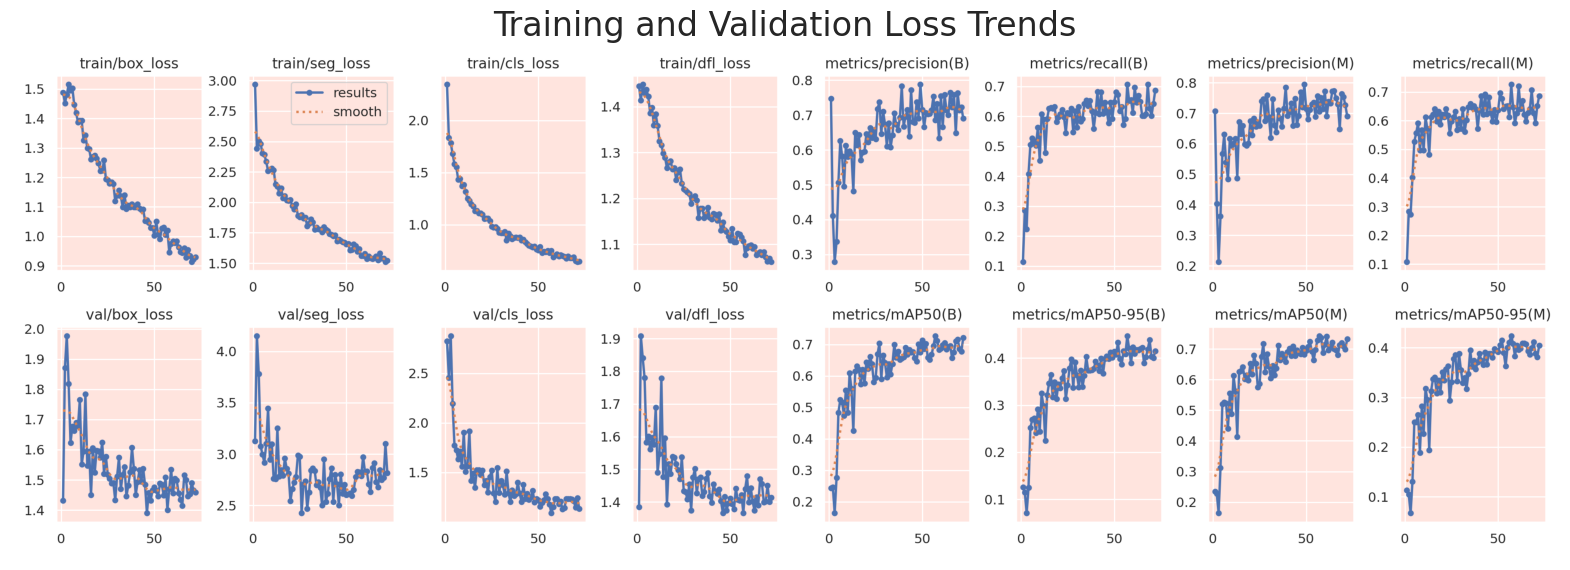

In [ ]:
# Create the full file path by joining the directory path with the filename
results_file_path = os.path.join(post_training_files_path, 'results.png')

# Read the image using cv2
image = cv2.imread(results_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(20, 8))
plt.imshow(image)
plt.title('Training and Validation Loss Trends', fontsize=24)
plt.axis('off')
plt.show()

In [ ]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title, ylim_range=[0,2]):
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='blue', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='#ed2f00', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(ylim_range)
    plt.legend()
    plt.show()

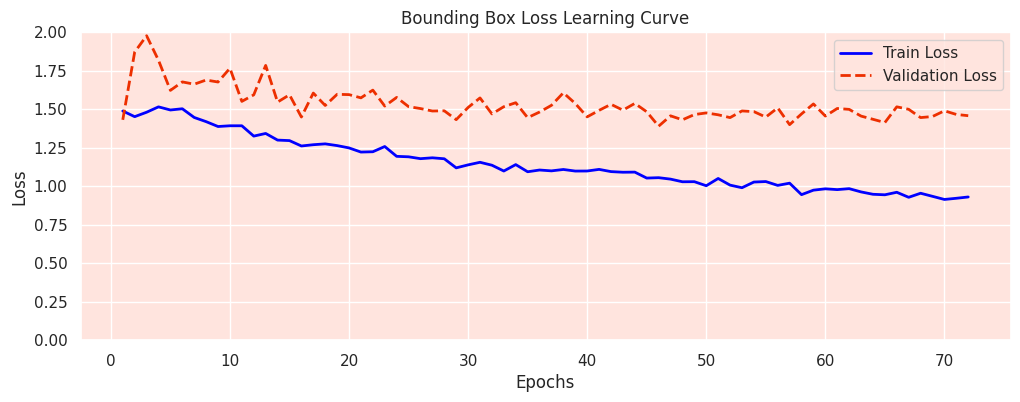

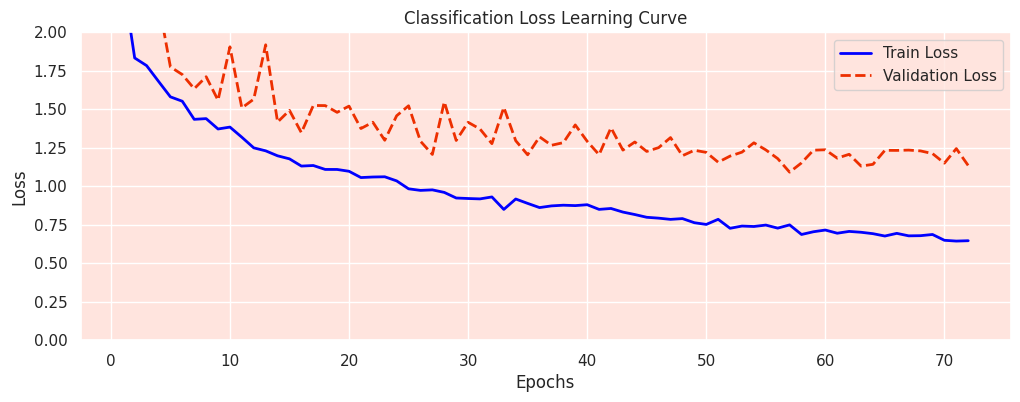

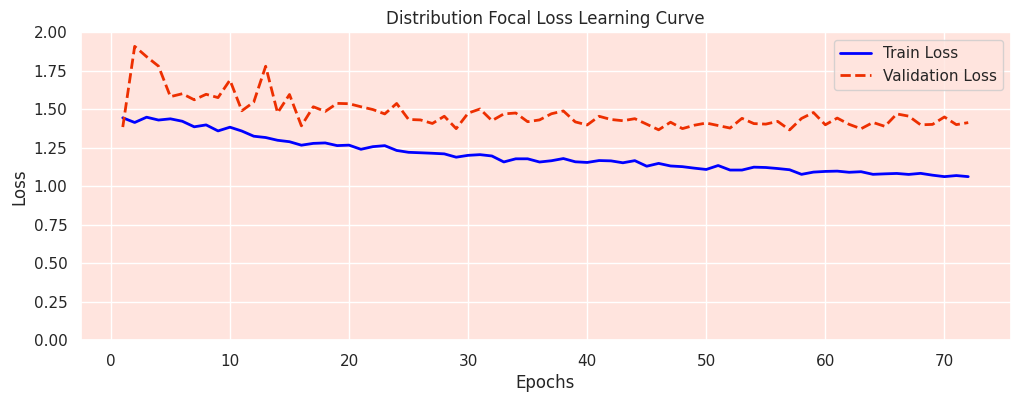

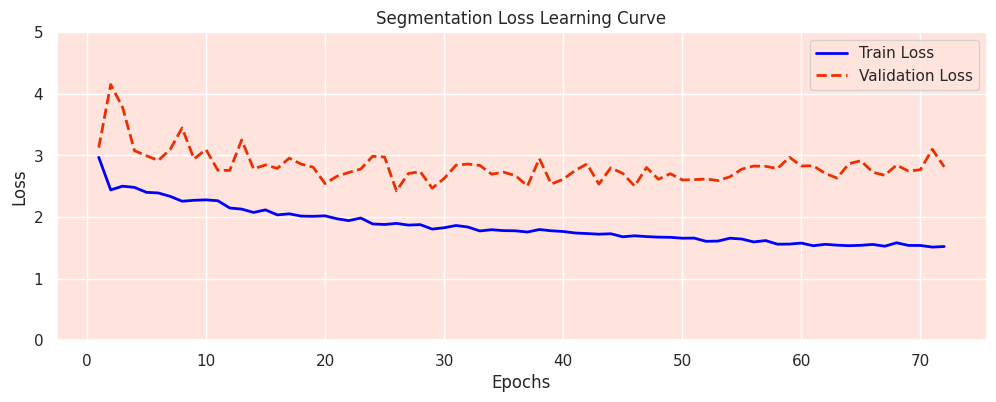

In [ ]:
# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Bounding Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')
plot_learning_curve(df, 'train/seg_loss', 'val/seg_loss', 'Segmentation Loss Learning Curve', ylim_range=[0,5])

###**Step 5.2:Confidence Threshold Metrics Analysis**

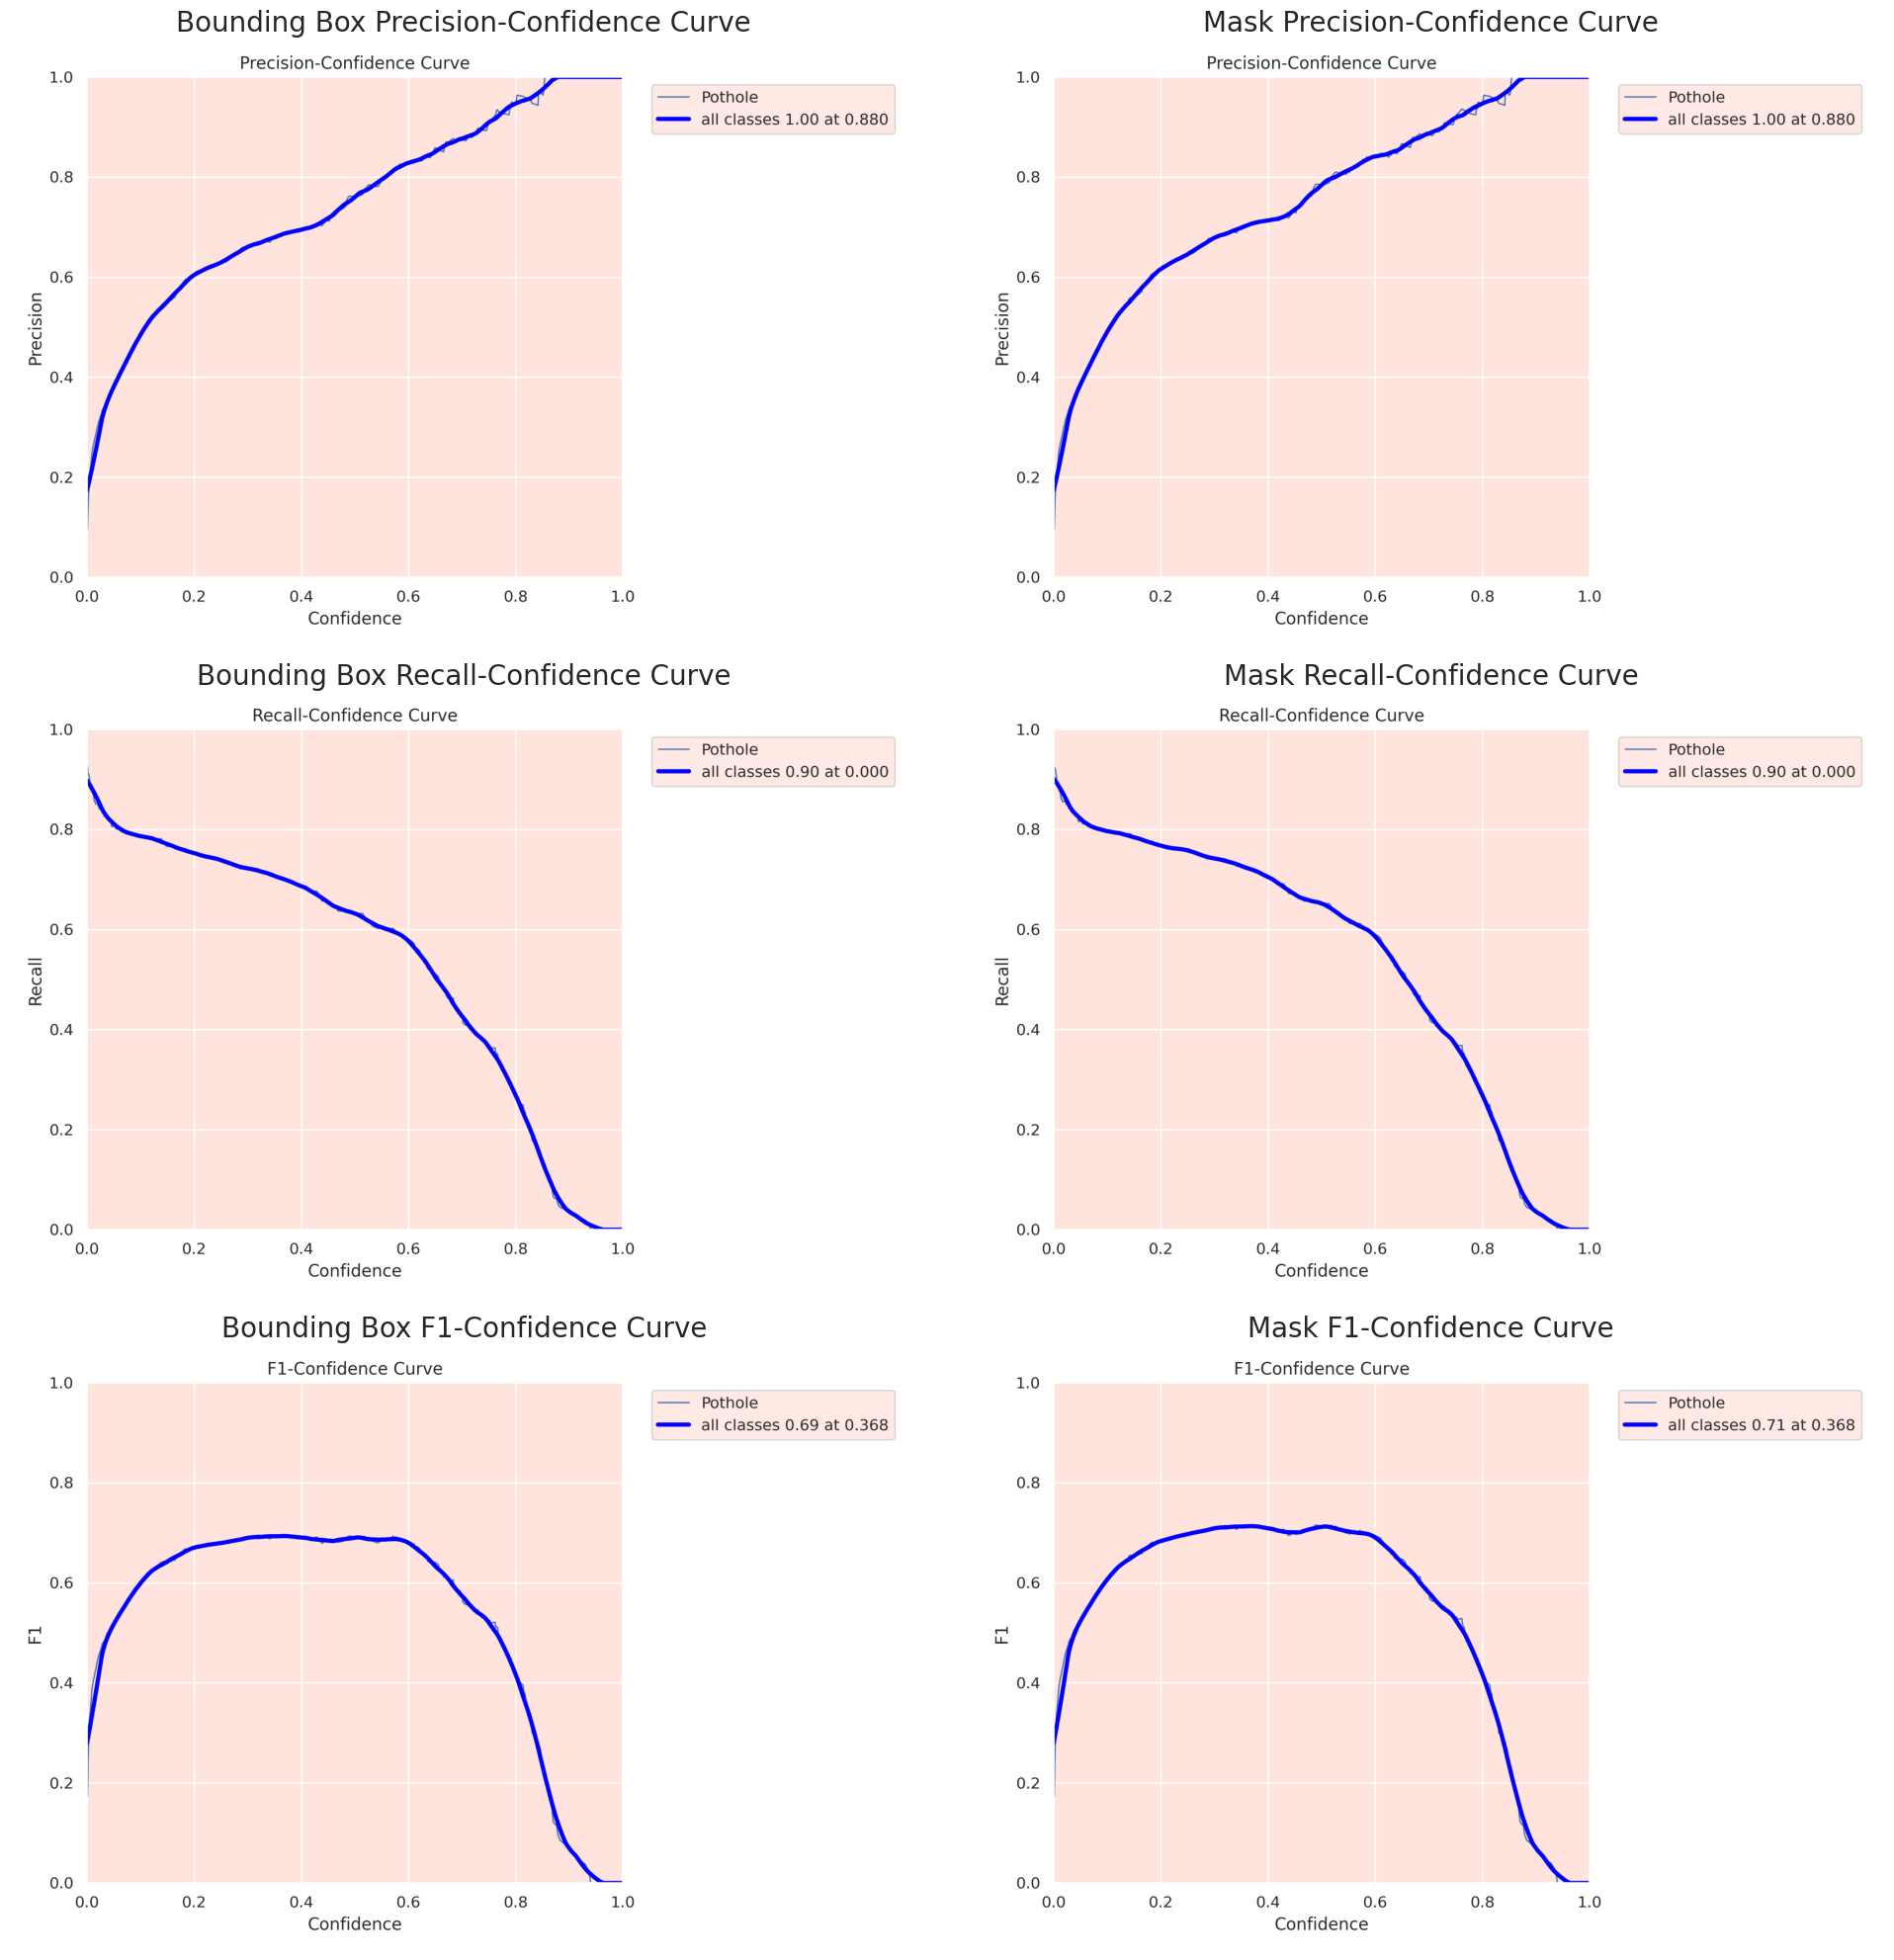

In [ ]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
box_files_titles = {
    'BoxP_curve.png': 'Bounding Box Precision-Confidence Curve',
    'BoxR_curve.png': 'Bounding Box Recall-Confidence Curve',
    'BoxF1_curve.png': 'Bounding Box F1-Confidence Curve'
}
mask_files_titles = {
    'MaskP_curve.png': 'Mask Precision-Confidence Curve',
    'MaskR_curve.png': 'Mask Recall-Confidence Curve',
    'MaskF1_curve.png': 'Mask F1-Confidence Curve'
}

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Function to read and convert image for plotting
def read_and_convert_image(file_path):
    # Read the image using cv2
    image = cv2.imread(file_path)
    # Convert from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot 'Box' images in the first column with meaningful titles
for i, (filename, title) in enumerate(box_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(title, fontsize=20)
    axs[i, 0].axis('off')

# Plot 'Mask' images in the second column with meaningful titles
for i, (filename, title) in enumerate(mask_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(title, fontsize=20)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

###**Step 5.3: Precision-Recall Curve Analysis**

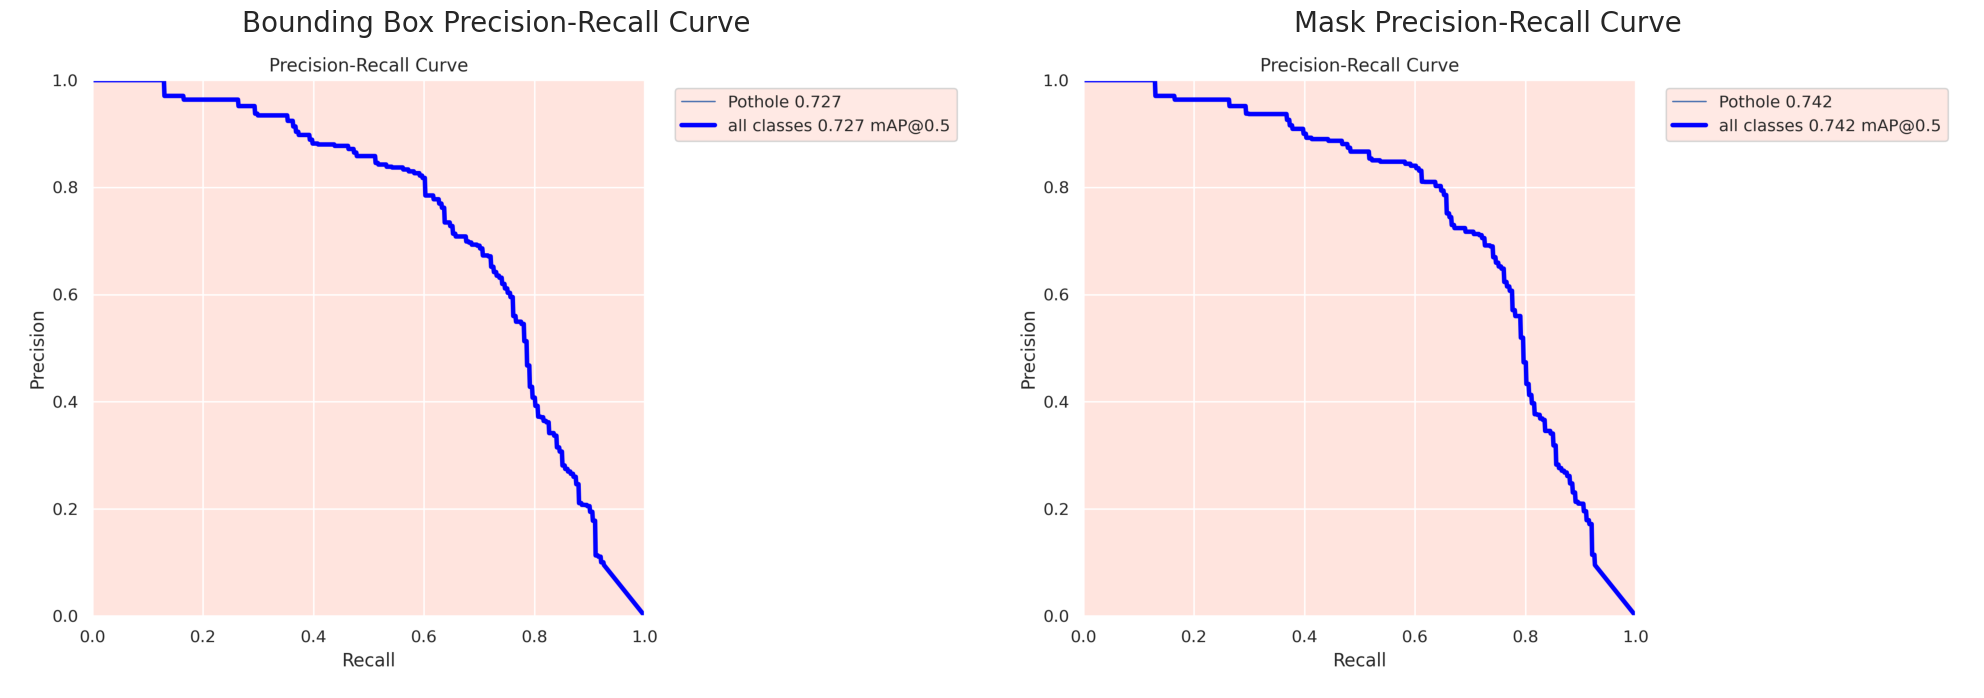

In [ ]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
pr_files_titles = {
    'BoxPR_curve.png': 'Bounding Box Precision-Recall Curve',
    'MaskPR_curve.png': 'Mask Precision-Recall Curve'
}

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 'Box' and 'Mask' images in the subplot with meaningful titles
for i, (filename, title) in enumerate(pr_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

###**Step 5.4: Confusion Matrix Analysis**

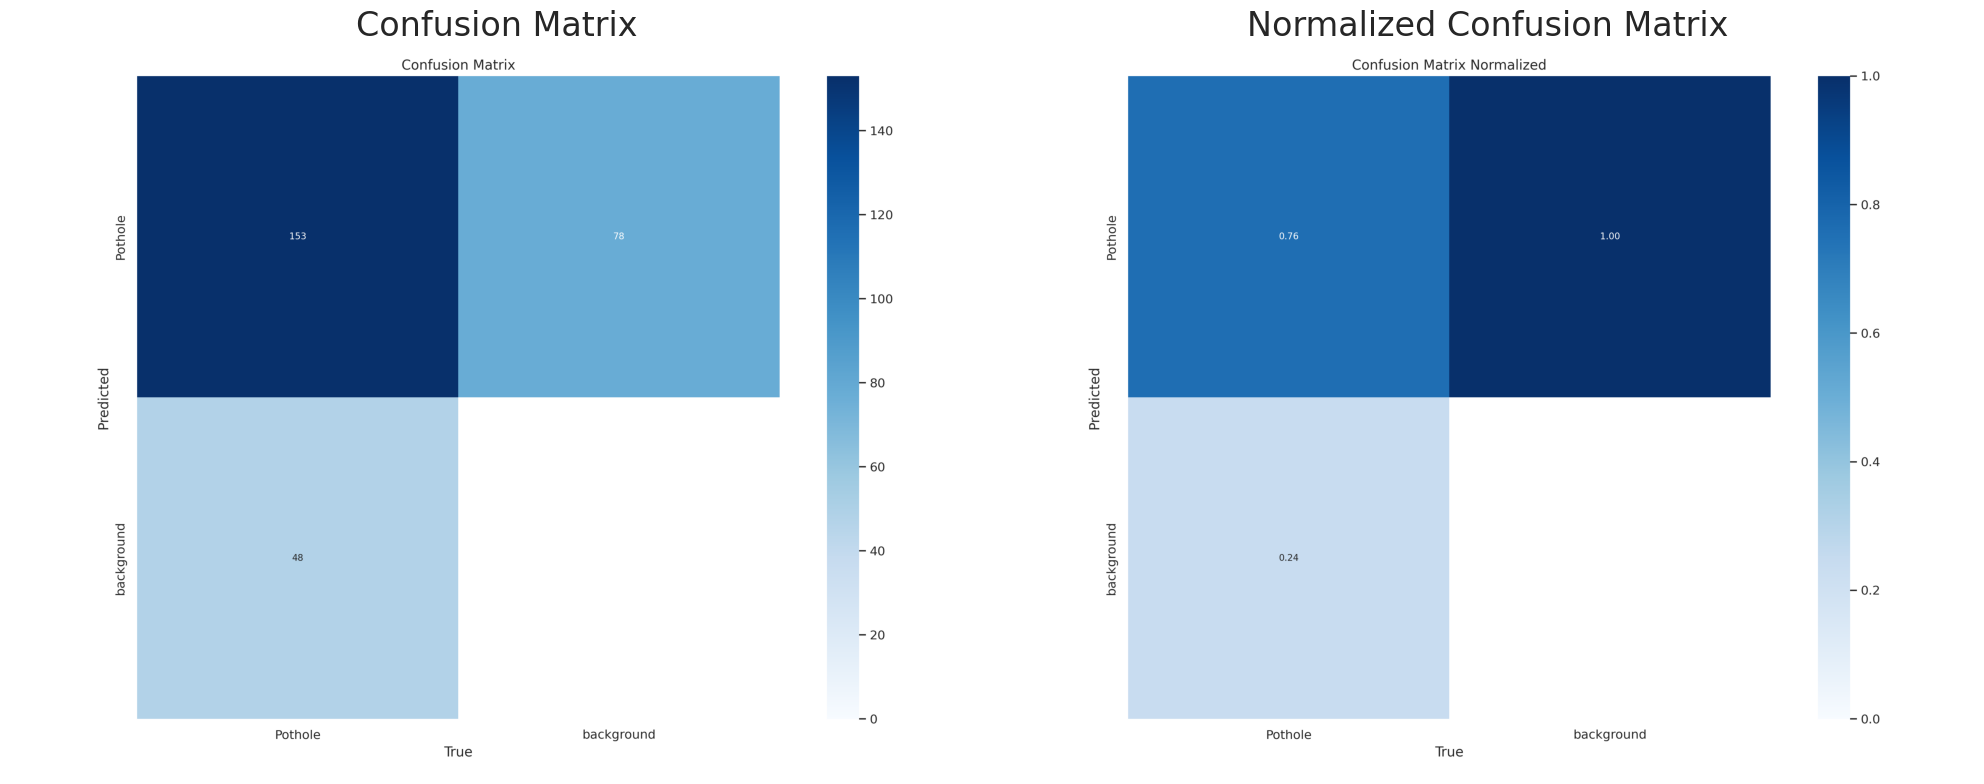

In [ ]:
# Construct the path to the confusion matrix images
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix.png')
confusion_matrix_normalized_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Read and convert both images
cm_img = read_and_convert_image(confusion_matrix_path)
cm_norm_img = read_and_convert_image(confusion_matrix_normalized_path)

# Display the images
axs[0].imshow(cm_img)
axs[0].set_title('Confusion Matrix', fontsize=24)
axs[0].axis('off')

axs[1].imshow(cm_norm_img)
axs[1].set_title('Normalized Confusion Matrix', fontsize=24)
axs[1].axis('off')

plt.tight_layout()
plt.show()

###**Step 5.5: Validation Performance Metrics Assessment**

In [ ]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/extracted_data/Pothole_Segmentation_YOLOv8/valid/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all         60        201      0.684      0.706      0.727      0.448      0.703      0.726      0.741      0.422
Speed: 0.5ms preprocess, 26.9ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/val


In [ ]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

,Metric Value
metrics/precision(B),0.684
metrics/recall(B),0.706
metrics/mAP50(B),0.727
metrics/mAP50-95(B),0.448
metrics/precision(M),0.703
metrics/recall(M),0.726
metrics/mAP50(M),0.741
metrics/mAP50-95(M),0.422
fitness,0.930


###**Step 6: Model Inference**

To effectively evaluate how well our model performs on new data, I'll carry out inferences in two key stages:

*   Inference on Validation Images
*   Inference on a New Test Video




###**Step 6.1: Inference on Validation Images**

In [ ]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640)
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

###**Step 6.2: Inference on a New Test Video**

In [ ]:
# Define the path to the sample video in the dataset
dataset_video_path = '/content/extracted_data/Pothole_Segmentation_YOLOv8/sample_video.mp4'

# Define the destination path in the working directory
video_path = '/content/sample_video.mp4'

# Copy the video file from its original location in the dataset to the current working directory in Kaggle
shutil.copyfile(dataset_video_path, video_path)

# Initiate vehicle detection on the sample video using the best performing model and save the output
best_model.predict(source=video_path, save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/375) /content/sample_video.mp4: 384x640 4 Potholes, 11.3ms
video 1/1 (frame 2/375) /content/sample_video.mp4: 384x640 5 Potholes, 15.9ms
video 1/1 (frame 3/375) /content/sample_video.mp4: 384x640 5 Potholes, 11.6ms
video 1/1 (frame 4/375) /content/sample_video.mp4: 384x640 3 Potholes, 11.3ms
video 1/1 (frame 5/375) /content/sample_video.mp4: 384x640 5 Potholes, 12.8ms
video 1/1 (frame 6/375) /content/sample_video.mp4: 384x640 7 Potho

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'Pothole'}
 obb: None
 orig_img: array([[[146, 137, 129],
         [177, 168, 160],
         [178, 169, 161],
         ...,
         [246, 243, 244],
         [246, 243, 244],
         [246, 243, 244]],
 
        [[197, 188, 180],
         [206, 197, 189],
         [164, 155, 147],
         ...,
         [246, 243, 244],
         [246, 243, 244],
         [246, 243, 244]],
 
        [[150, 141, 133],
         [183, 174, 166],
         [188, 179, 171],
         ...,
         [246, 243, 244],
         [246, 243, 244],
         [246, 243, 244]],
 
        ...,
 
        [[ 80,  92, 102],
         [ 70,  82,  92],
         [ 63,  75,  85],
         ...,
         [ 61,  81, 101],
         [ 62,  82, 102],
         [ 65,  85, 105]],
 
        [[ 70,  82,  92],
         [ 63,  75,  85],
         [ 59,  71,  8

In [ ]:
from moviepy.editor import VideoFileClip

# Define the path to the input .avi file and output .mp4 file
input_video_path = '/content/road_damage_assessment.avi'
output_video_path = '/content/sample_video.mp4'

# Load the .avi video file
video_clip = VideoFileClip(input_video_path)

# Write the video file to .mp4 format
video_clip.write_videofile(output_video_path, codec='libx264')

# Display the video in the notebook
from IPython.display import Video
Video(output_video_path, embed=True, width=960)


In [ ]:
# Export the model
best_model.export(format='onnx')

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/segment/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (6.5 MB)

ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 1.6s, saved as '/content/runs/segment/train/weights/best.onnx' (12.6 MB)

Export complete (4.6s)
Results saved to /content/runs/segment/train/weights
Predict:         yolo predict task=segment model=/content/runs/segment/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=segment model=/content/runs/segment/train/weights/best.onnx imgsz=640 data=/content/extracted_data/Pothole_Segmentation_YOLOv8/data.yaml  
Visualize:       https://netron.app


'/content/runs/segment/train/weights/best.onnx'

###**Step 7: Real-Time Road Damage**


image 1/1 /content/extracted_data/Pothole_Segmentation_YOLOv8/valid/images/pic-303-_jpg.rf.236ed95889a91baf47b304faa7cbae01.jpg: 640x640 (no detections), 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


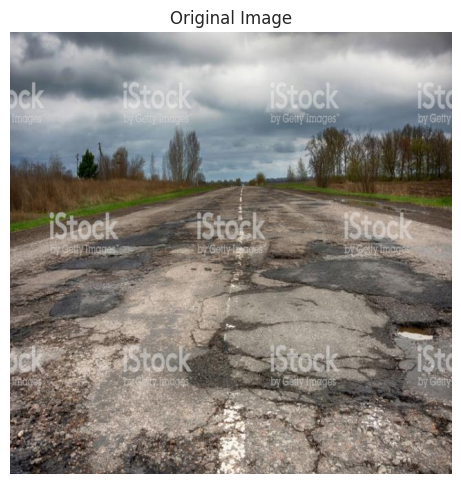

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select a sample image
selected_image = image_files[45]

# Perform inference on the selected image
image_path = os.path.join(valid_images_path, selected_image)
results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
annotated_image = results[0].plot()
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Determine the number of subplots needed (1 original + number of masks)
num_subplots = 1 + (len(results[0].masks.data) if results[0].masks is not None else 0)

# Initialize the subplot with 1 row and n columns
fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

# If there's only one subplot, axes is not a list but a single Axes object
if num_subplots == 1:
    axes = [axes]

# Display the original annotated image
axes[0].imshow(annotated_image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# If multiple masks, iterate and display each mask
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()
    for i, mask in enumerate(masks):
        # Threshold the mask to make sure it's binary
        # Any value greater than 0 is set to 255, else it remains 0
        binary_mask = (mask > 0).astype(np.uint8) * 255
        axes[i+1].imshow(binary_mask, cmap='gray')
        axes[i+1].set_title(f'Segmented Mask {i+1}')
        axes[i+1].axis('off')

# Adjust layout and display the subplot
plt.tight_layout()
plt.show()


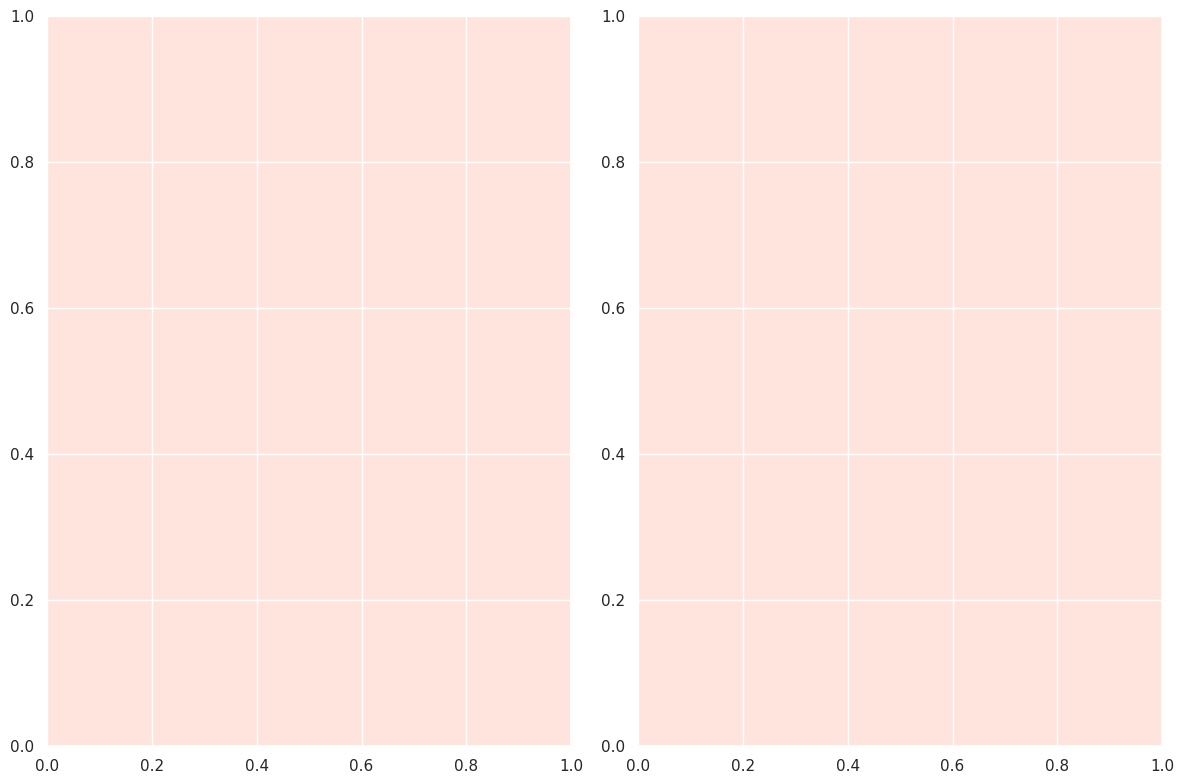

--------------------------------------------------
Total Damaged Area by Potholes: 0 pixels
Total Pixels in Image: 921600 pixels
Percentage of Road Damaged: 0.00%


In [ ]:
# Initialize variables to hold total area and individual areas
total_area = 0
area_list = []

# Set up the subplot for displaying masks
fig, axes = plt.subplots(1, len(masks), figsize=(12, 8))

# Perform operations if masks are available
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()   # Retrieve masks as numpy arrays
    image_area = masks.shape[1] * masks.shape[2]  # Calculate total number of pixels in the image
    for i, mask in enumerate(masks):
        binary_mask = (mask > 0).astype(np.uint8) * 255  # Convert mask to binary
        color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)  # Convert binary mask to color
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the binary mask
        contour = contours[0]  # Retrieve the first contour
        area = cv2.contourArea(contour)  # Calculate the area of the pothole
        area_list.append(area)  # Append area to the list
        cv2.drawContours(color_mask, [contour], -1, (0, 255, 0), 3)  # Draw the contour on the mask

        # Display the mask with the green contour
        axes[i].imshow(color_mask)
        axes[i].set_title(f'Pothole {i+1}')
        axes[i].axis('off')

# Display all masks
plt.tight_layout()
plt.show()

# Calculate and print areas after displaying the images
for i, area in enumerate(area_list):
    print(f"Area of Pothole {i+1}: {area} pixels")
    total_area += area  # Sum the areas for total

# Calculate and print the total damaged area and percentage of road damaged by potholes
print("-"*50)
print(f"Total Damaged Area by Potholes: {total_area} pixels")
print(f"Total Pixels in Image: {image_area} pixels")
print(f"Percentage of Road Damaged: {(total_area / image_area) * 100:.2f}%")

In [ ]:
# Define the video path
video_path = '/content/sample_video.mp4'

# Define font, scale, colors, and position for the annotation
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
text_position = (40, 80)
font_color = (255, 255, 255)    # White color for text
background_color = (0, 0, 255)  # Red background for text

# Initialize a deque with fixed length for averaging the last 10 percentage damages
damage_deque = deque(maxlen=10)

# Open the video
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('road_damage_assessment.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Read until video is completed
while cap.isOpened():
     # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        # Perform inference on the frame
        results = best_model.predict(source=frame, imgsz=640, conf=0.25)
        processed_frame = results[0].plot(boxes=False)

        # Initializes percentage_damage to 0
        percentage_damage = 0

        # If masks are available, calculate total damage area and percentage
        if results[0].masks is not None:
            total_area = 0
            masks = results[0].masks.data.cpu().numpy()
            image_area = frame.shape[0] * frame.shape[1]  # total number of pixels in the image
            for mask in masks:
                binary_mask = (mask > 0).astype(np.uint8) * 255
                contour, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                total_area += cv2.contourArea(contour[0])

            percentage_damage = (total_area / image_area) * 100

        # Calculate and update the percentage damage
        damage_deque.append(percentage_damage)
        smoothed_percentage_damage = sum(damage_deque) / len(damage_deque)

        # Draw a thick line for text background
        cv2.line(processed_frame, (text_position[0], text_position[1] - 10),
                 (text_position[0] + 350, text_position[1] - 10), background_color, 40)

        # Annotate the frame with the percentage of damage
        cv2.putText(processed_frame, f'Road Damage: {smoothed_percentage_damage:.2f}%', text_position, font, font_scale, font_color, 2, cv2.LINE_AA)

        # Write the processed frame to the output video
        out.write(processed_frame)

        # Uncomment the following 3 lines if running this code on a local machine to view the real-time processing results
        # cv2.imshow('Road Damage Assessment', processed_frame) # Display the processed frame
        # if cv2.waitKey(1) & 0xFF == ord('q'): # Press Q on keyboard to exit the loop
        #     break
    else:
        break

# Release the video capture and video write objects
cap.release()
out.release()

# Close all the frames
# cv2.destroyAllWindows()


0: 384x640 2 Potholes, 63.0ms
Speed: 11.8ms preprocess, 63.0ms inference, 109.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Potholes, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Potholes, 31.4ms
Speed: 2.4ms preprocess, 31.4ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Potholes, 12.0ms
Speed: 2.5ms preprocess, 12.0ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pothole, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pothole, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pothole, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pothole, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 3.3ms postprocess per image at 

In [ ]:
from moviepy.editor import VideoFileClip

# Load the AVI video
clip = VideoFileClip("/content/road_damage_assessment.avi")

# Convert to MP4
clip.write_videofile("/content/road_damage_assessment.mp4", codec="libx264")


Moviepy - Building video /content/road_damage_assessment.mp4.
Moviepy - Writing video /content/road_damage_assessment.mp4



Moviepy - Done !
Moviepy - video ready /content/road_damage_assessment.mp4
